# Renta Autos Jack

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson


# Entorno

In [5]:
# Maximo num d ecarros en cada locacion
MAX_CAR = 20
# maximo num de carros a mover en la noche
MAX_MUEVE_CAR = 5
# numero esperado de rentas en la primera locacion (lambda) ¿funcinoa este problema si cambio las lambdas llego a lo mismo?
RENTAS_LOC1 = 3
RENTAS_LOC2 = 4

# Numero esperado de retornos en cada locacion (lambda)
RETORNOS_LOC1 = 3
RETORNOS_LOC2 = 2 # Hay error encodigodel video
# credito ganado por un carro
RENTA_GANANCIA = 10
# Costo de mover un carro
COSTO_MOVER = 2


In [6]:
# Limite superior para la distribucion de Poisson
POISSON_LIMIT_SUP = 11
""" si n (numero de carros rentados/requeridos) pasa de este valor, 
automaticamente se truna la probabilidad de obtener n a 0 """

# Se almacena en un diccionario las probabilidaes de la distribucion un especie de cache
poisson_cache = dict()

def probabilidad_poisson(n, lam):
    global poisson_cache
    key = 10*n + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n,lam)
    return poisson_cache[key]



In [7]:
# probabilidad de rentar 2 coches con un valor esperado de 3, valor medio de cuantos carros se rentan al dia
probabilidad_poisson(2,3) 

0.22404180765538775

In [8]:
poisson_cache.items()

dict_items([(23, 0.22404180765538775)])

## Agente

In [9]:
# Descuento
gamma = 0.9

# Acciones
acciones = np.arange(-MAX_MUEVE_CAR, MAX_MUEVE_CAR+1)


## Algoritmo de iteracion de politica
- Recurrimos a ecuacion de bellman
- Algoritmo de iteracion de politica que tiene dos bloques 1. estima la funcion de valor de las acciones y 2. la mejor politica

- el estado es un arreglo con el numero de autos por localidad `estado = [numCarsLoc1,numCarsLoc2]`
- acciones seran positivas si paso de Loc1 a Loc2 y negativas si paso autos de Loc2 a Loc1
- la funcion de valor estado es una Matriz de valores de estado
- en la matriz valor de estado 5,3 significa que me pidan 5 carros en loc1 y 3 carros en loc2

## Simplificacion computacional
se plantea usar una variable `retorno_constante_car` para devolver un valor constante deretorno de carros y no desde la distribucion de poisson. Esto aligera el computo. Pedir auto para rentar sigue siendo un evento probabilistico

In [10]:
def retorno_esperado(estado, 
                     accion,
                     valor_estado,
                     retorno_constante_car):
    # init el retorno
    el_retorno = 0
    # decontar sihemos movido
    el_retorno -= COSTO_MOVER*abs(accion)
    # el retorno es rl, otro retorno significa devolver el carro
    # mover carros
    NUM_CAR_LOC1 = min(estado[0]-accion, MAX_CAR)
    NUM_CAR_LOC2 = min(estado[1]+accion, MAX_CAR)

    # Programacion dinamica sincrona
    # barrer todos los estados
    for num_rentas_LOC1 in range(POISSON_LIMIT_SUP):
        for num_rentas_LOC2 in range(POISSON_LIMIT_SUP):
            # probabilidad deque pida autos
            # prob independiente
            prob = probabilidad_poisson(num_rentas_LOC1, RENTAS_LOC1)*probabilidad_poisson(num_rentas_LOC2, RENTAS_LOC2) # media esperada de la distribucion es lambda
            num_car_LOC1 = NUM_CAR_LOC1
            num_car_LOC2 = NUM_CAR_LOC2
            # limite o numerode rentas validas
            rentas_valid_LOC1 = min(num_car_LOC1, num_rentas_LOC1)
            rentas_valid_LOC2 = min(num_car_LOC2, num_rentas_LOC2)

            #actualizar numero de carros
            num_car_LOC1 -= rentas_valid_LOC1
            num_car_LOC2 -= rentas_valid_LOC2
            # obtengo una ganancia
            recompensa = (rentas_valid_LOC1+rentas_valid_LOC2)*RENTA_GANANCIA

            if retorno_constante_car:
                # me llega el mismo numero de carros
                # a;adir carros para usarlos en els= sgente dia enla siguiente iteracion
                retornos_LOC1 = RETORNOS_LOC1
                retornos_LOC2 = RETORNOS_LOC2
                num_car_LOC1 = min(num_car_LOC1+retornos_LOC1, MAX_CAR)
                num_car_LOC2 = min(num_car_LOC2+retornos_LOC2, MAX_CAR)

                # Ecuacion de Bellman
                el_retorno+=prob*(recompensa+gamma*valor_estado[num_car_LOC1, num_car_LOC2])
            else:
                # caso no simplificado
                # probabilidad de que ocurra una renta y probabilidad de que ocurra un retorno 
                for retornos_LOC1 in range(POISSON_LIMIT_SUP):
                    for retornos_LOC2 in range(POISSON_LIMIT_SUP):
                        # prob de retornar un auto
                        prob_retornar = probabilidad_poisson(retornos_LOC1, RETORNOS_LOC1)*\
                            probabilidad_poisson(retornos_LOC2, RETORNOS_LOC2)
                        prob_ = prob*prob_retornar # prob total son eventos independientes
                        # luego de hacer el retorno ajusto numero de auutos totales
                        num_car_LOC1 = min(num_car_LOC1+retornos_LOC1, MAX_CAR)
                        num_car_LOC2 = min(num_car_LOC2+retornos_LOC2, MAX_CAR)

                        # Eq Bellman
                        el_retorno +=prob_*(recompensa+gamma*valor_estado[num_car_LOC1, num_car_LOC2])
    return el_retorno

## Algoritmo de Iteracion de Politica


In [18]:
def evaluacion_mejora(retorno_constante_car):
    valor = np.zeros((MAX_CAR+1, MAX_CAR+1))
    politica = np.zeros(valor.shape, dtype=np.int64)
    # revisar video1 para como funciona la poltiica 
    _, axes = plt.subplots(2,3,figsize=(40,20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    # inicio contador deiteraciones
    iteraciones = 0
    while True:
        # loop infinito que se ingresa cada vez que la politica no es buena
        fig = sns.heatmap(np.flipud(politica), cmap="YlGnBu", ax=axes[iteraciones])
        fig.set_ylabel("# Carros Loc1", fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CAR+1))))
        fig.set_xlabel("# Carros LOC2", fontsize=30)
        fig.set_title("Politica {}".format(iteraciones), fontsize=30)
        
        # evaluacion en su lugar
        while True:
            # barrido por todos los estados posibles
            valor_viejo = valor.copy() # verificar cambio de estados
            for i in range(MAX_CAR+1):
                for j in range(MAX_CAR+1):
                    #calcular retorno esperado con bellman
                    nuevo_valor_estado = retorno_esperado([i,j], politica[i,j], valor,retorno_constante_car)
                    valor[i,j] = nuevo_valor_estado

            # condicion de paro que diga si los estados cambian en cuadricula que la suma de estados sea peque;o
            max_valor_cambio = abs(valor_viejo-valor).max() # matriz de diferencias se guarda el valor que mas cambia
            print(f"Max valor que el estado cambio: {max_valor_cambio}")
            if max_valor_cambio < 1e-4:
                break # se termina evaluacion
        # mejora de la politica
        politica_estable = True
        for i in range(MAX_CAR+1):
            for j in range(MAX_CAR+1):
                accion_vieja = politica[i,j]
                el_retorno_accion = []
                for accion in acciones:
                    if (0 <= accion <=i) or (-j <= accion <=0):
                        el_retorno_accion.append(retorno_esperado([i,j], accion, valor, retorno_constante_car))
                    else:
                        el_retorno_accion.append(-np.inf)
                # eq de bellman
                nueva_accion = acciones[np.argmax(el_retorno_accion)]
                politica[i,j] = nueva_accion

                if politica_estable and accion_vieja != nueva_accion:
                    politica_estable = False
        print(f"Politica Estable: {politica_estable}")

        if politica_estable:
            fig = sns.heatmap(np.flipud(valor), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel("# Carros Loc1", fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CAR+1))))
            fig.set_xlabel("# Carros LOC2", fontsize=30)
            fig.set_title("Valor Optimo {}".format(iteraciones), fontsize=30)
            break
        iteraciones+=1
    plt.show()
    plt.close()    

Max valor que el estado cambio: 77.0390915765931
Max valor que el estado cambio: 68.23879195531826
Max valor que el estado cambio: 61.016322068787346
Max valor que el estado cambio: 54.25881083920987
Max valor que el estado cambio: 48.07516106297501
Max valor que el estado cambio: 42.5844930776974
Max valor que el estado cambio: 37.72008746678125
Max valor que el estado cambio: 33.41128079766736
Max valor que el estado cambio: 29.594669422317395
Max valor que el estado cambio: 26.214033895329635
Max valor que el estado cambio: 23.219572502530127
Max valor que el estado cambio: 20.5671721225616
Max valor que el estado cambio: 18.21775870634258
Max valor que el estado cambio: 16.136721679793197
Max valor que el estado cambio: 14.293404077222192
Max valor que el estado cambio: 12.660650915905535
Max valor que el estado cambio: 11.214409160216121
Max valor que el estado cambio: 9.933373382469654
Max valor que el estado cambio: 8.798671900204113
Max valor que el estado cambio: 7.79358876656

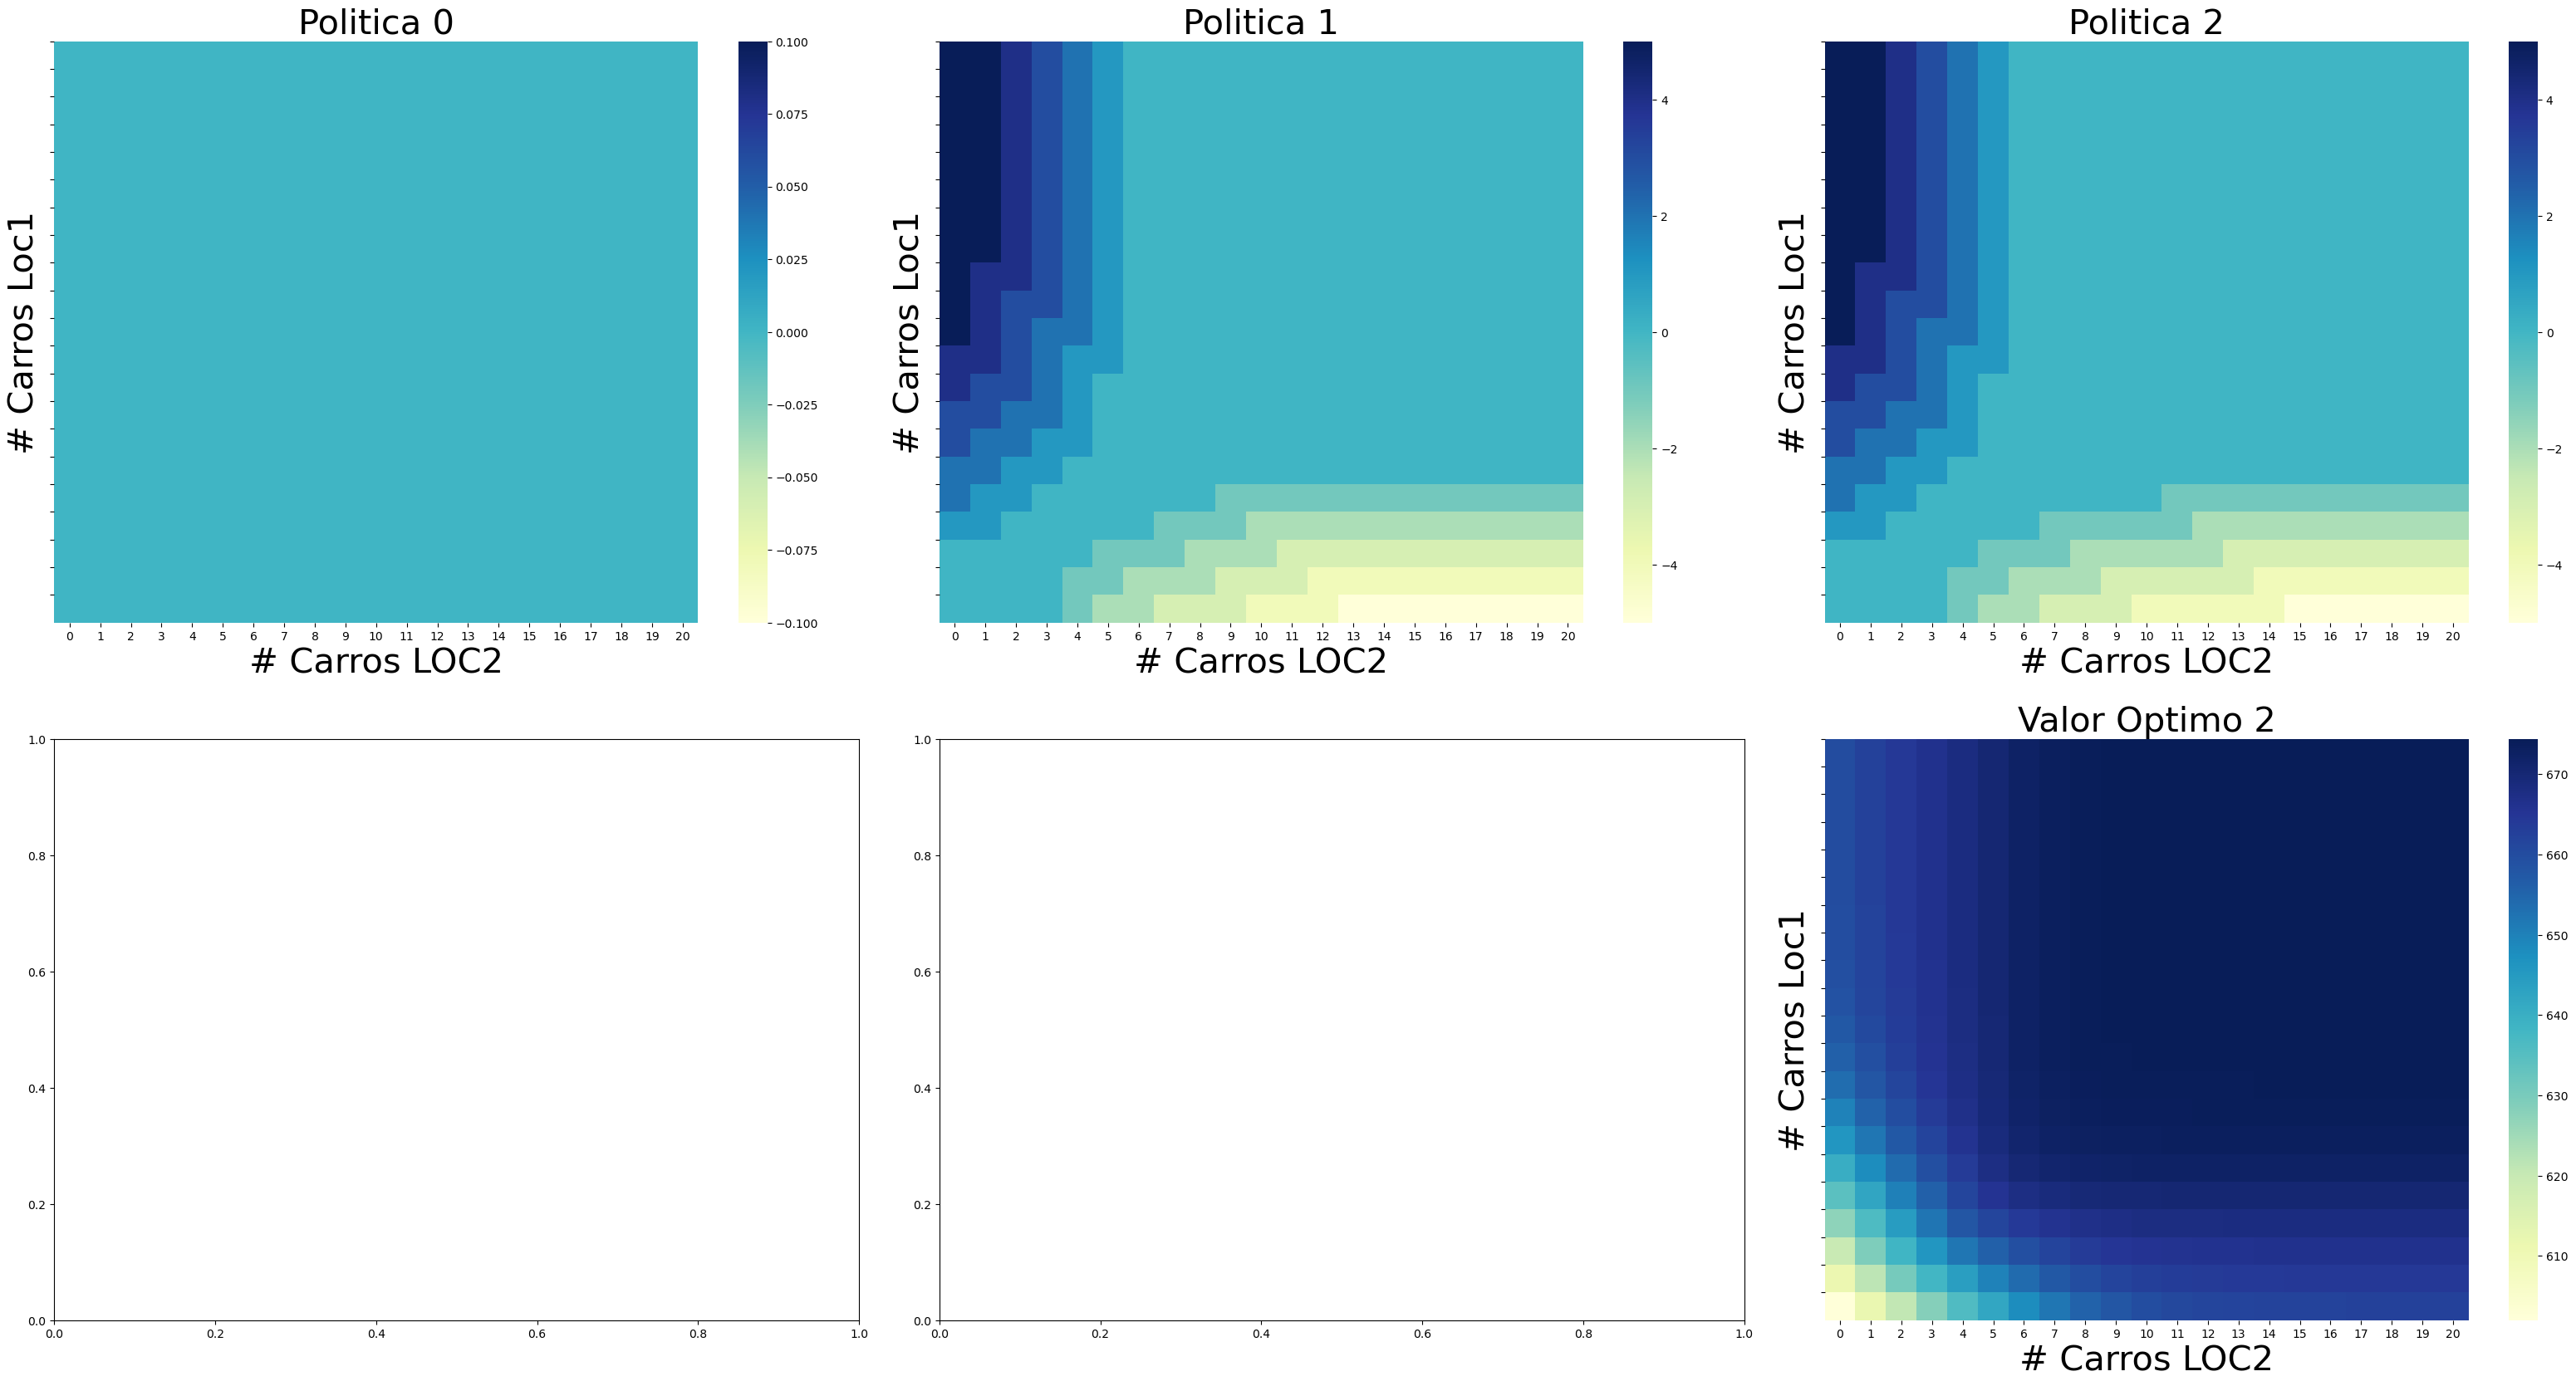

CPU times: user 17min 11s, sys: 48.6 ms, total: 17min 11s
Wall time: 17min 11s


In [21]:
%%time
evaluacion_mejora(retorno_constante_car=False)